In [1]:
import numpy as np
import polars as pl
from sklearn.cluster import KMeans

In [3]:
df = pl.read_csv('../../Ressources/municipalities_coordinates_newest.csv')

In [7]:
# Coordinates
coords = df.select(['Latitude', 'Longitude']).to_numpy()

# Clustering
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(coords)
centers = kmeans.cluster_centers_

# Add cluster assignments
municipalities_df = df.with_columns(
    pl.Series('cluster', clusters)
)

# Add center coordinates
center_coords = np.array([centers[cluster] for cluster in clusters])
municipalities_df = municipalities_df.with_columns([
    pl.Series('center_latitude', center_coords[:, 0]),
    pl.Series('center_longitude', center_coords[:, 1])
])

# --- Find closest municipality to each cluster center ---
municipality_names = df['Municipality'].to_list()

cluster_center_municipality = {}

for cluster_id in range(k):
    # Indices of points in this cluster
    indices = np.where(clusters == cluster_id)[0]

    # Their coordinates
    cluster_points = coords[indices]

    # Compute distances to cluster center
    dists = np.linalg.norm(cluster_points - centers[cluster_id], axis=1)

    # Find the closest one
    closest_index = indices[np.argmin(dists)]
    cluster_center_municipality[cluster_id] = municipality_names[closest_index]

# Map each row’s cluster to its center municipality
center_name_column = [cluster_center_municipality[c] for c in clusters]

# Add to dataframe
municipalities_df = municipalities_df.with_columns(
    pl.Series('center_municipality', center_name_column)
)


In [8]:
centers

array([[46.62293596,  6.68270968],
       [47.35796658,  8.3959449 ],
       [47.05684287,  9.39510739],
       [46.18340531,  8.90749454],
       [47.1896638 ,  7.46919631],
       [46.47300804,  7.69190078]])

In [9]:
municipalities_df

Municipality,Latitude,Longitude,cluster,center_latitude,center_longitude,center_municipality
str,f64,f64,i32,f64,f64,str
"""Aeugst am Albis""",47.267949,8.4863301,1,47.357967,8.395945,"""Rudolfstetten-Friedlisberg"""
"""Affoltern am Albis""",47.278247,8.4521518,1,47.357967,8.395945,"""Rudolfstetten-Friedlisberg"""
"""Bonstetten""",47.315466,8.4670602,1,47.357967,8.395945,"""Rudolfstetten-Friedlisberg"""
"""Hausen am Albis""",47.243877,8.534235,1,47.357967,8.395945,"""Rudolfstetten-Friedlisberg"""
"""Hedingen""",47.298441,8.4489755,1,47.357967,8.395945,"""Rudolfstetten-Friedlisberg"""
…,…,…,…,…,…,…
"""Rocourt""",47.390504,6.9569559,4,47.189664,7.469196,"""Leuzigen"""
"""Saint-Ursanne""",47.364603,7.1539488,4,47.189664,7.469196,"""Leuzigen"""
"""Seleute""",47.366362,7.1132195,4,47.189664,7.469196,"""Leuzigen"""


In [12]:
mun_to_csv = municipalities_df['Municipality', 'center_municipality']
mun_to_csv.write_csv('municiaplities_to_cluster_centroid.csv')

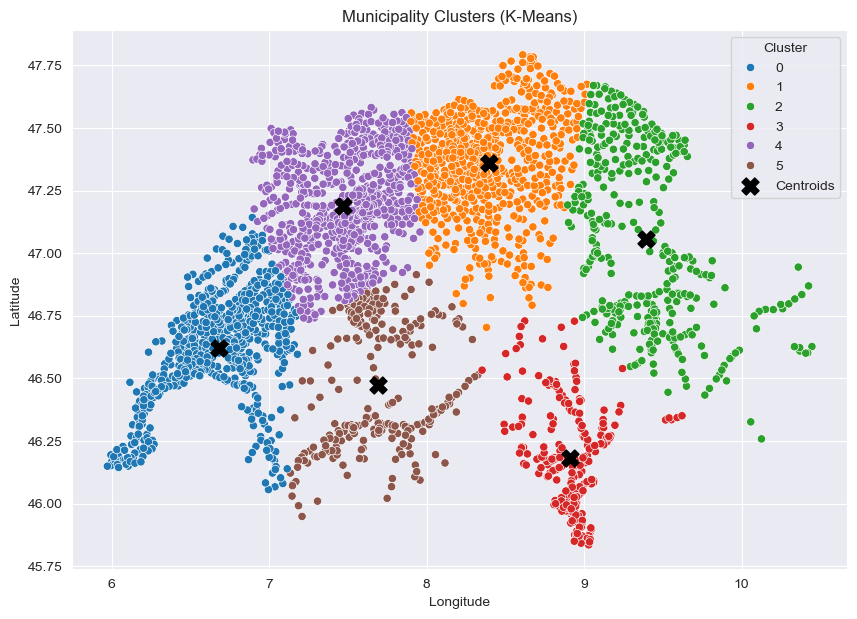

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))

# Plotting the clusters with seaborn
sns.scatterplot(
    x='Longitude', y='Latitude', hue='cluster',
    palette='tab10', data=municipalities_df, legend='full'
)
plt.scatter(
    centers[:, 1],  # Longitude of cluster centers
    centers[:, 0],  # Latitude of cluster centers
    c='black',      # Color for cluster centers
    s=150,          # Size of cluster centers points
    marker='X',     # Marker type
    label='Centroids'  # Label for legend
)
# Plotting the centers (assuming centers is a numpy array from KMeans)

plt.title('Municipality Clusters (K-Means)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.show()


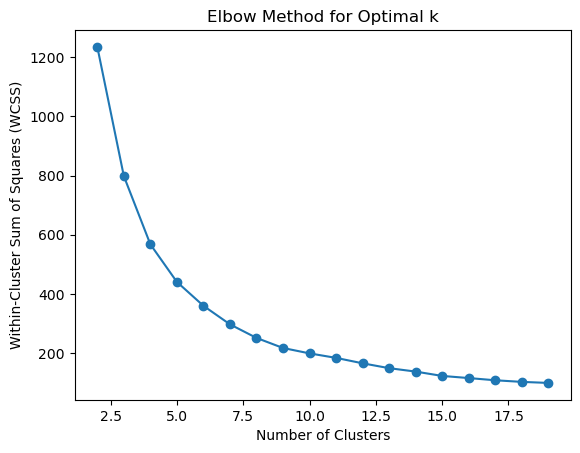

In [176]:
wcss = []  # within-cluster sum of squares
for i in range(2, 20):  # testing cluster range from 2 to 20
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(coords)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 20), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [198]:
main_data_df = pl.read_csv('/Users/nilsgamperli/Documents/StormMindData/main_data.csv')

In [199]:
main_data_df

Municipality,Date,extent_of_damage,main_process
str,str,f64,f64
"""Aeugst am Albis""","""1972-02-17""",0.0,0.0
"""Aeugst am Albis""","""1972-02-18""",0.0,0.0
"""Aeugst am Albis""","""1972-02-19""",0.0,0.0
"""Aeugst am Albis""","""1972-02-20""",0.0,0.0
"""Aeugst am Albis""","""1972-02-21""",0.0,0.0
…,…,…,…
"""Vendlincourt""","""2023-12-19""",0.0,0.0
"""Vendlincourt""","""2023-12-20""",0.0,0.0
"""Vendlincourt""","""2023-12-21""",0.0,0.0


In [200]:
# Join main_data with municipalities_df on 'municipality' to bring in the cluster
main_data_df = main_data_df.join(
    municipalities_df.select(['Municipality', 'cluster', 'center_municipality']),
    on='Municipality',
    how='left'
)

In [201]:
main_data_df = main_data_df['Date', 'center_municipality', 'cluster', 'extent_of_damage']

In [202]:
main_data_df

Date,center_municipality,cluster,extent_of_damage
str,str,i32,f64
"""1972-02-17""","""Rudolfstetten-Friedlisberg""",4,0.0
"""1972-02-18""","""Rudolfstetten-Friedlisberg""",4,0.0
"""1972-02-19""","""Rudolfstetten-Friedlisberg""",4,0.0
"""1972-02-20""","""Rudolfstetten-Friedlisberg""",4,0.0
"""1972-02-21""","""Rudolfstetten-Friedlisberg""",4,0.0
…,…,…,…
"""2023-12-19""","""Selzach""",0,0.0
"""2023-12-20""","""Selzach""",0,0.0
"""2023-12-21""","""Selzach""",0,0.0


In [205]:
import polars as pl
import itertools

# Skip if 'Date' already parsed
"""
main_data_df = main_data_df.with_columns(
    pl.col('Date').str.strptime(pl.Date, "%Y-%m-%d")
)
"""

# Extract week and year
main_data_df = main_data_df.with_columns([
    pl.col("Date").map_elements(
        lambda d: d.isocalendar()[0], return_dtype=pl.Int64
    ).alias("year"),
    pl.col("Date").map_elements(
        lambda d: d.isocalendar()[1], return_dtype=pl.Int64
    ).alias("week")
])

# Unique values
clusters = main_data_df.select('cluster').unique()['cluster'].to_list()
years = main_data_df.select('year').unique()['year'].to_list()
weeks = main_data_df.select('week').unique()['week'].to_list()

# Full grid
full_index = pl.DataFrame(
    list(itertools.product(years, weeks, clusters)),
    schema=['year', 'week', 'cluster']
)

# Filter + count
non_zero_df = main_data_df.filter(pl.col('extent_of_damage') != 0.0)
weekly_counts = non_zero_df.group_by(['year', 'week', 'cluster']).agg(
    pl.count().alias('count_non_zero_damage')
)

# Join count to full grid
result = full_index.join(weekly_counts, on=['year', 'week', 'cluster'], how='left').with_columns(
    pl.col('count_non_zero_damage').fill_null(0)
)

# Now: join in center_municipality info from main_data_df
# (Assuming it's the same per cluster, so we take distinct cluster-center_municipality pairs)
center_info = main_data_df.select(['cluster', 'center_municipality']).unique()

# Final result with cluster center names
result = result.join(center_info, on='cluster', how='left')


/var/folders/hl/p763nlw90_5fw2097x_zh3ph0000gn/T/ipykernel_6981/4111008042.py:27: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  full_index = pl.DataFrame(
/var/folders/hl/p763nlw90_5fw2097x_zh3ph0000gn/T/ipykernel_6981/4111008042.py:35: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('count_non_zero_damage')


In [206]:
result

year,week,cluster,count_non_zero_damage,center_municipality
i64,i64,i64,u32,str
1992,15,0,0,"""Selzach"""
1992,15,3,1,"""Mels"""
1992,15,4,0,"""Rudolfstetten-Friedlisberg"""
1992,15,1,0,"""Cugnasco"""
1992,15,2,1,"""Poliez-Pittet"""
…,…,…,…,…
2021,53,3,0,"""Mels"""
2021,53,4,0,"""Rudolfstetten-Friedlisberg"""
2021,53,1,0,"""Cugnasco"""


In [208]:
import datetime


# Function to get Sunday of ISO week
def iso_week_to_sunday(year: int, week: int) -> datetime.date:
    try:
        monday = datetime.date.fromisocalendar(year, week, 1)
        sunday = monday + datetime.timedelta(days=6)
        return sunday
    except ValueError:
        monday = datetime.date.fromisocalendar(year, week-1, 1)
        sunday = monday + datetime.timedelta(days=6)
        return sunday

# Apply function to create a new column
result_wiht_date = result.with_columns(
    pl.struct(['year', 'week']).map_elements(
        lambda x: iso_week_to_sunday(x['year'], x['week']),
        return_dtype=pl.Date
    ).alias('sunday_date')
)

In [209]:
result_wiht_date

year,week,cluster,count_non_zero_damage,center_municipality,sunday_date
i64,i64,i64,u32,str,date
1992,15,0,0,"""Selzach""",1992-04-12
1992,15,3,1,"""Mels""",1992-04-12
1992,15,4,0,"""Rudolfstetten-Friedlisberg""",1992-04-12
1992,15,1,0,"""Cugnasco""",1992-04-12
1992,15,2,1,"""Poliez-Pittet""",1992-04-12
…,…,…,…,…,…
2021,53,3,0,"""Mels""",2022-01-02
2021,53,4,0,"""Rudolfstetten-Friedlisberg""",2022-01-02
2021,53,1,0,"""Cugnasco""",2022-01-02


In [212]:
result_wiht_date = result_wiht_date.rename({'center_municipality': 'Municipality', 'sunday_date': 'Date', 'count_non_zero_damage': 'combination_damage_mainprocess'})

In [213]:
result_wiht_date = result_wiht_date['Municipality', 'Date', 'combination_damage_mainprocess']

In [215]:
result_wiht_date.write_csv('../../Ressources/aggregated_main_data.csv')